# Calculate emissions changes in well-mixed gas levels
Calculate the emissions changes in well-mixed gases at hemisphereic and globally averaged levels. 

In [1]:
import netCDF4 as nc
import pandas as pd
from math import floor
import matplotlib.pyplot as plt
import numpy as np

import os
import sys

sys.path.append(os.getcwd())
from utils import copy_netcdf_file, insert_interpolated_point, cutoff_netcdf_time

In [2]:
# Input gas levels
input_folder = "../input/"
output_folder = "../output/GHGs/"
input_co2_mole = "mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_201501-250012.nc"
input_no2_mole = "mole-fraction-of-nitrous-oxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_201501-250012.nc"
input_ch4_mole = "mole-fraction-of-methane-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_201501-250012.nc"

# We need to know the names of relevant variables in each of the different files
gases = {"co2": input_co2_mole, "n2o": input_no2_mole, "ch4": input_ch4_mole}
key_variables = {
    "co2": "mole_fraction_of_{}_in_air".format("carbon_dioxide"),
    "n2o": "mole_fraction_of_{}_in_air".format("nitrous_oxide"), 
    "ch4": "mole_fraction_of_{}_in_air".format("methane")
}
path_var_names = {"co2": "CO2(ppm)", "n2o": "N2O(ppb)", "ch4": "CH4(ppb)"}

# Modification factors
mod_input_folder = "../../COVID19_emissions_data/global_pathways/"
mod_input_baseline = "Base_pathway.xlsx"
mod_input_ff = "FossilFuel_pathway.xlsx"
mod_input_2yr= "TwoYearBlip_pathway.xlsx"
mod_input_mg = "ModerateGreen_pathway.xlsx"
mod_input_sg = "StrongGreen_pathway.xlsx"

pathway_files = [mod_input_ff, mod_input_2yr, mod_input_mg, mod_input_sg]

year_range = np.arange(2020, 2050.01)
t0 = 2019
tcutoff = (2050.01 - 1850) * 365

In [3]:
baseline = pd.read_excel(mod_input_folder + mod_input_baseline, header=0, index_col=1, sheet_name="Concentrations")
baseline

,Unnamed: 0,CO2(ppm),CH4(ppb),N2O(ppb),CF4(ppt),C2F6(ppt),C6F14(ppt),HFC23(ppt),HFC32(ppt),HFC43_10(ppt),...,MCF(ppt),HCFC22(ppt),HCFC141B(ppt),HCFC142B(ppt),HALON1211(ppt),HALON1202(ppt),HALON1301(ppt),HALON2402(ppt),CH3BR(ppt),CH3CL(ppt)
year,,,,,,,,,,,,,,,,,,,,,
1765.000000,0,278.051482,722.000000,273.000000,34.497000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,13.097500,547.996000
1765.083333,1,278.053979,722.305474,273.000557,34.496996,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,12.580582,533.047268
1765.166667,2,278.056513,722.608177,273.001192,34.496993,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,12.114799,519.293771
1765.250000,3,278.059079,722.908133,273.001906,34.496989,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,11.695094,506.639942
1765.333333,4,278.061673,723.205366,273.002698,34.496986,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,11.316909,494.997858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049.666667,3416,510.935593,1684.252143,331.774161,103.400447,6.414414,0.463972,27.994719,0.368850,0.223915,...,0.003593,185.588524,18.035510,8.631796,0.809577,7.797257e-09,2.207218,0.046639,7.804962,408.880765
2049.750000,3417,511.186976,1683.934684,331.817722,103.450925,6.419025,0.464384,27.984971,0.365706,0.223434,...,0.003533,184.631904,17.981470,8.599584,0.806205,7.576387e-09,2.205016,0.046449,7.804962,408.880765
2049.833333,3418,511.438382,1683.617378,331.861276,103.501373,6.423634,0.464796,27.975218,0.362579,0.222954,...,0.003475,183.677920,17.927447,8.567460,0.802846,7.361773e-09,2.202814,0.046259,7.804962,408.880765


In [4]:
def calc_means(df, year_range):
    to_return = pd.DataFrame(index=year_range, columns=["mean"])
    for year in year_range:
        to_return["mean"][year] = np.nanmean(df[df["year"].floordiv(1) == year][df.columns[1]])
    return to_return

In [5]:
def make_year_into_days(year):
    return (year - 1850 + 0.5) * 365 # The calendar is defined using the 365 day calendar. 

In [6]:
def closest_ind(info, time):
    return [np.where(
        abs(info - time) == min(abs(info - time))
    )[0][-1]]

In [7]:
monthly_range = [date for date in baseline.index if date >= min(year_range) and date < max(year_range) + 1]

Plot of scenario FossilFuel for co2
End time factor is 1.0161816721990533
Plot of scenario TwoYearBlip for co2
End time factor is 0.9971215151305272
Plot of scenario ModerateGreen for co2
End time factor is 0.8865059194619843
Plot of scenario StrongGreen for co2
End time factor is 0.8504880177184185
Plot of scenario FossilFuel for n2o
End time factor is 1.0016231794740995
Plot of scenario TwoYearBlip for n2o
End time factor is 0.9996665658202607
Plot of scenario ModerateGreen for n2o
End time factor is 0.9876659772215121
Plot of scenario StrongGreen for n2o
End time factor is 0.9707827288854481
Plot of scenario FossilFuel for ch4
End time factor is 1.04638080762552
Plot of scenario TwoYearBlip for ch4
End time factor is 0.9997434874768756
Plot of scenario ModerateGreen for ch4
End time factor is 0.8427478693564295
Plot of scenario StrongGreen for ch4
End time factor is 0.738968805862438


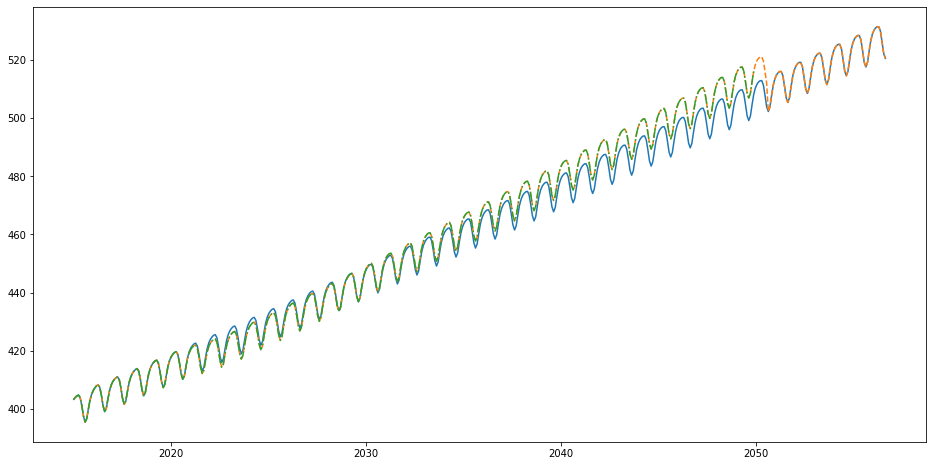

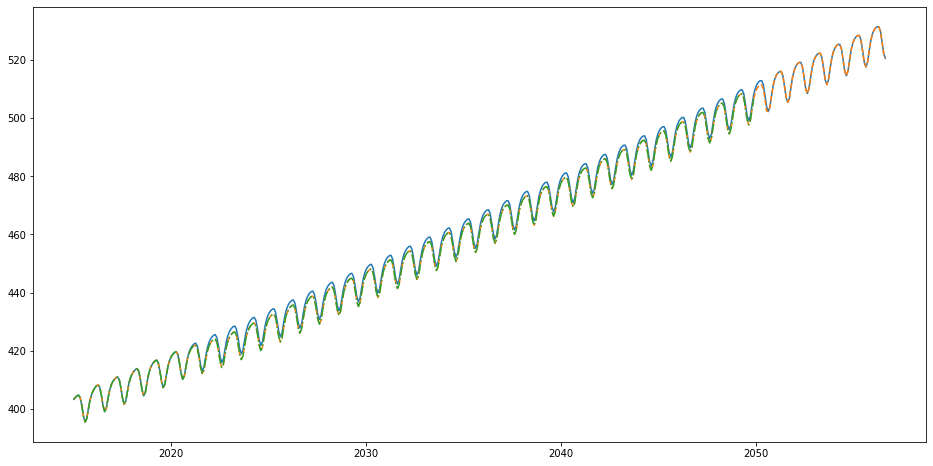

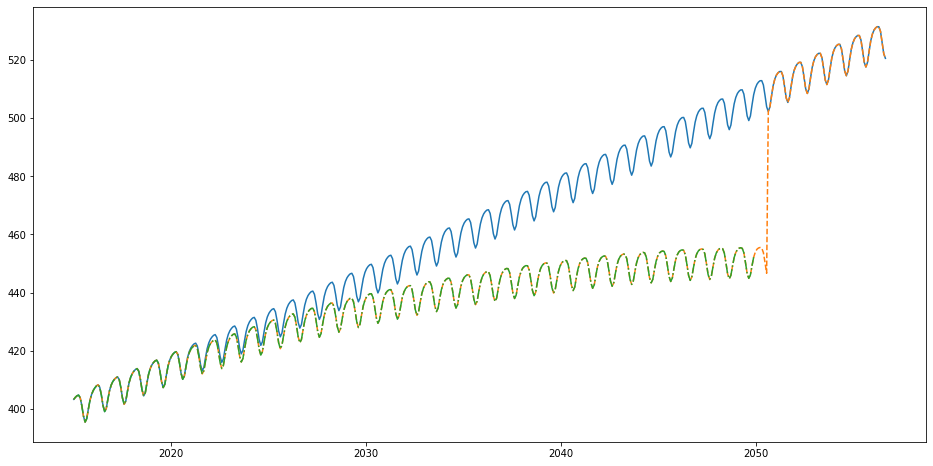

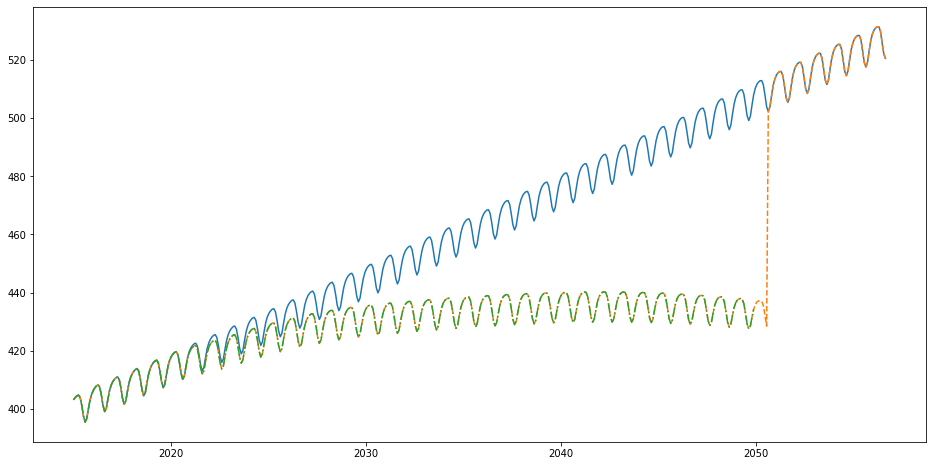

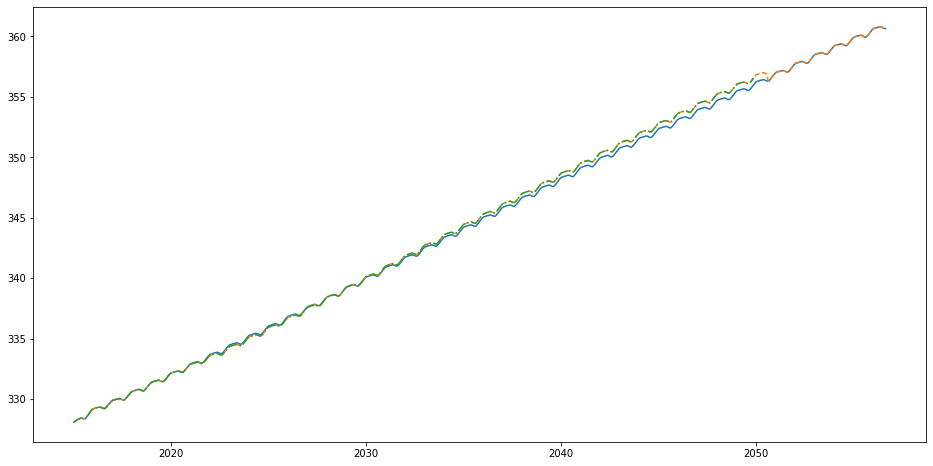

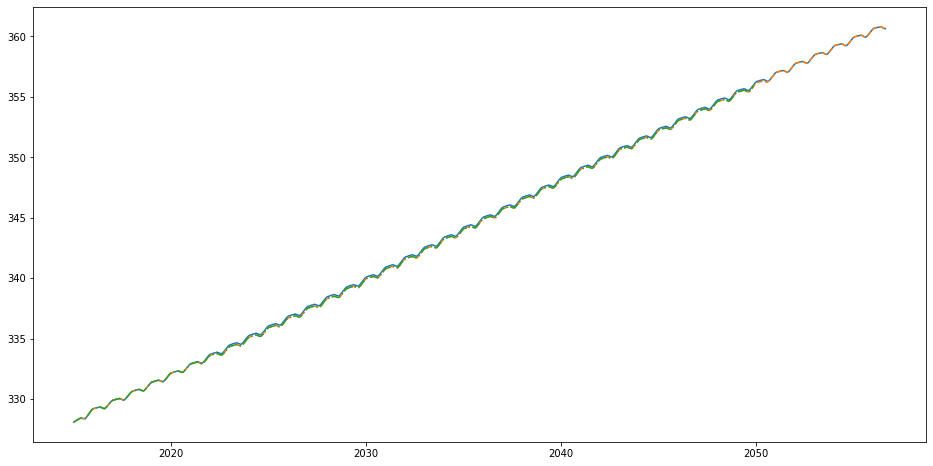

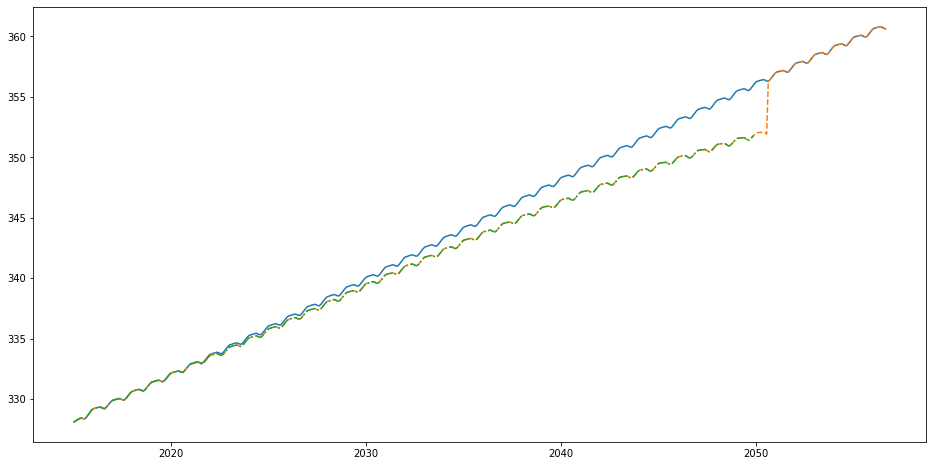

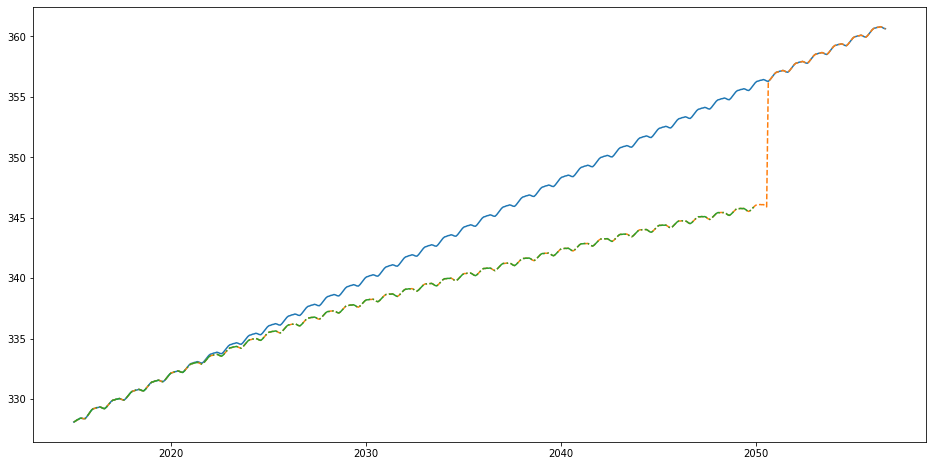

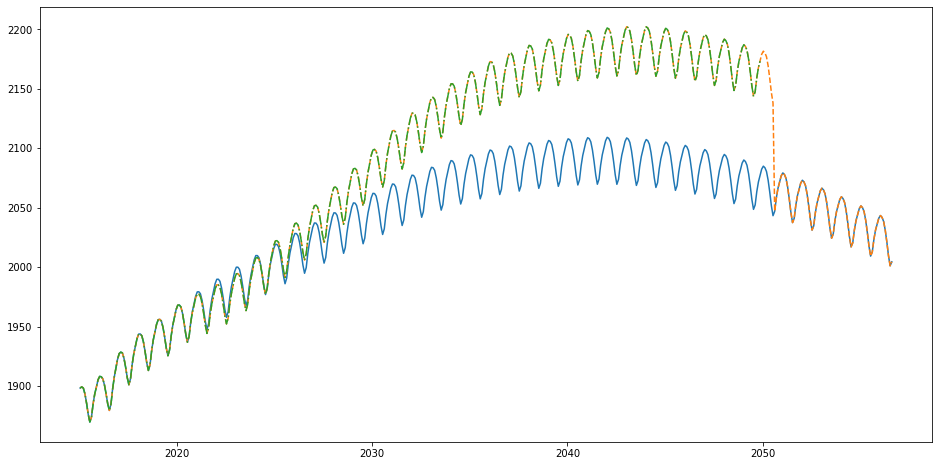

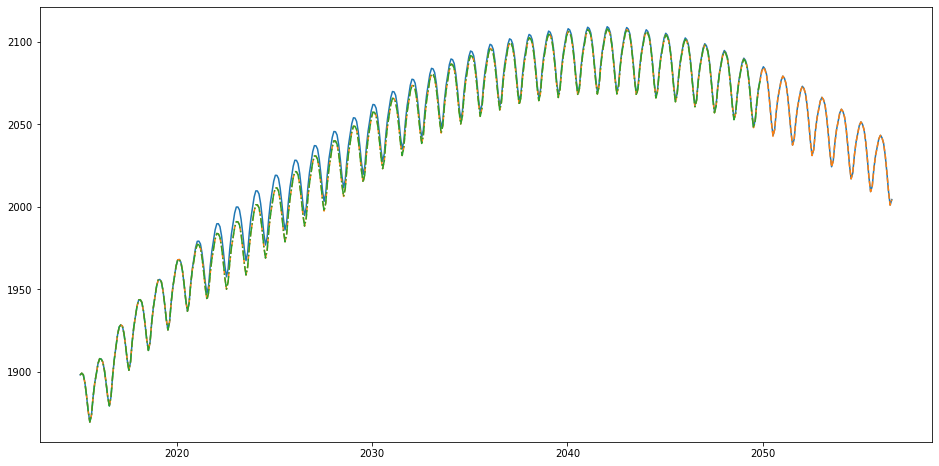

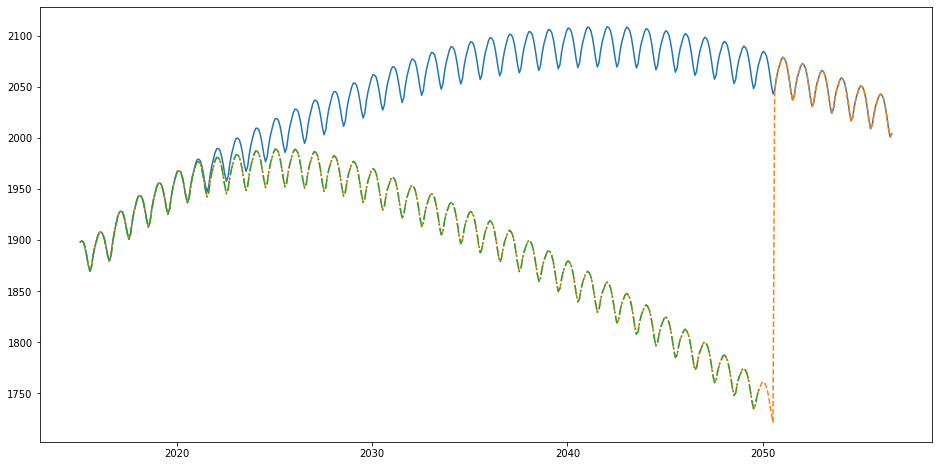

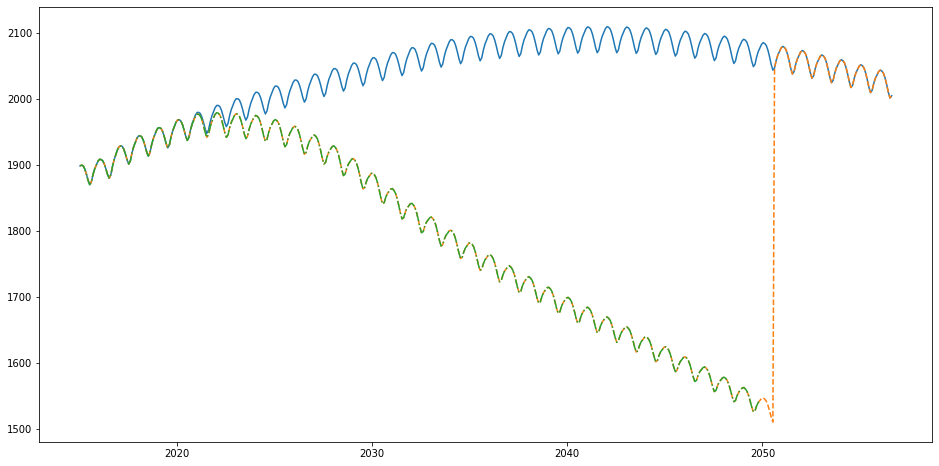

In [8]:
for gas, gas_file in gases.items():
    key_variable = key_variables[gas]
    for fileind in range(len(pathway_files)):
        file = pathway_files[fileind]
        scenario_string = file.split("_")[0]
        data = copy_netcdf_file(gas_file, input_folder, output_folder, scenario_string)
        output = data.variables[key_variable][...]
        path_df = pd.read_excel(mod_input_folder + file, header=0, index_col=1, sheet_name="Concentrations")
        #t0_ind = closest_ind(data.variables["time"][:], make_year_into_days(t0))
        #conc_at_t0 = output[t0_ind, :]
        for time in monthly_range:
            timeind = closest_ind(data.variables["time"][:], make_year_into_days(time))
            time_factor = path_df[path_var_names[gas]].loc[time] / baseline[path_var_names[gas]].loc[time]
            output[timeind, ...] = (output[timeind, :]) * time_factor # + conc_at_t0[0, :] # TODO: missing -conc term
        print("Plot of scenario {} for {}".format(scenario_string, gas))
        print("End time factor is {}".format(time_factor))
        plt.figure(figsize=(16, 8))
        plt.plot(data.variables["time"][:500] / 365 + 1850, data.variables[key_variable][:500, 1])
        plt.plot(data.variables["time"][:500] / 365 + 1850, output[:500, 1], linestyle="--")
        data.variables[key_variable][:, :] = output
        data.close()
        data = cutoff_netcdf_time(
            output_folder, output_folder, gas_file + scenario_string, tcutoff, scenario_string="_to_2050.nc"
        )
        plt.plot(data.variables["time"][:500] / 365 + 1850, data.variables[key_variable][:500, 1], linestyle="-.")
        data.close()
        

# Sandbox

In [9]:
blob

NameError: name 'blob' is not defined

In [ ]:
data.close()

In [ ]:
tcutoff

In [ ]:
data.variables["time"][-1] / 365 + 1850

In [ ]:
plt.plot(data.variables["time"][:])


In [ ]:
data = nc.Dataset(input_folder + gases["co2"])

In [ ]:
plt.plot(data.variables["time"][:410] / 365 + 1850, data.variables["mole_fraction_of_carbon_dioxide_in_air"][:410] * 0.88)

In [ ]:
data = nc.Dataset(output_folder+  gas_file + scenario_string)

In [ ]:
path_df[path_var_names[gas]].loc[time] / baseline[path_var_names[gas]].loc[time]

In [ ]:
data = cutoff_netcdf_time(
            output_folder, output_folder, gas_file + scenario_string, tcutoff, scenario_string="_to_2050.nc"
        )